In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras import layers
from keras import applications
import cv2
from tensorflow.keras.utils import plot_model

2023-05-20 23:29:31.694398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 23:29:32.617672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# /kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/
train_dir='dataset/train/'
test_dir='dataset/test/'

In [3]:
train=pd.read_csv('dataset/train.csv')
train.head(5)

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [4]:
test=pd.read_csv('dataset/test.csv')
test.head(5)

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [5]:
print("training data size is : ",train.shape[0])
print("testing data size is  : ",test.shape[0])

training data size is :  5508
testing data size is  :  2361


In [6]:
num=len(train['breed'].unique())
print("Total Labels : ",str(num))

Total Labels :  35


In [7]:
train['breed'].value_counts()

thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
thamnophis-radix               100
pantherophis-guttatus          100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
masticophis-flagellum           83
crotalus-viridis                83
thamnophis-marcianus            82
crotalus-ruber      

# Data augmentation

In [8]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

2023-05-20 23:29:33.989557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 23:29:34.090683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 23:29:34.090889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 23:29:34.092841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 23:29:34.093034: I tensorflow/compile

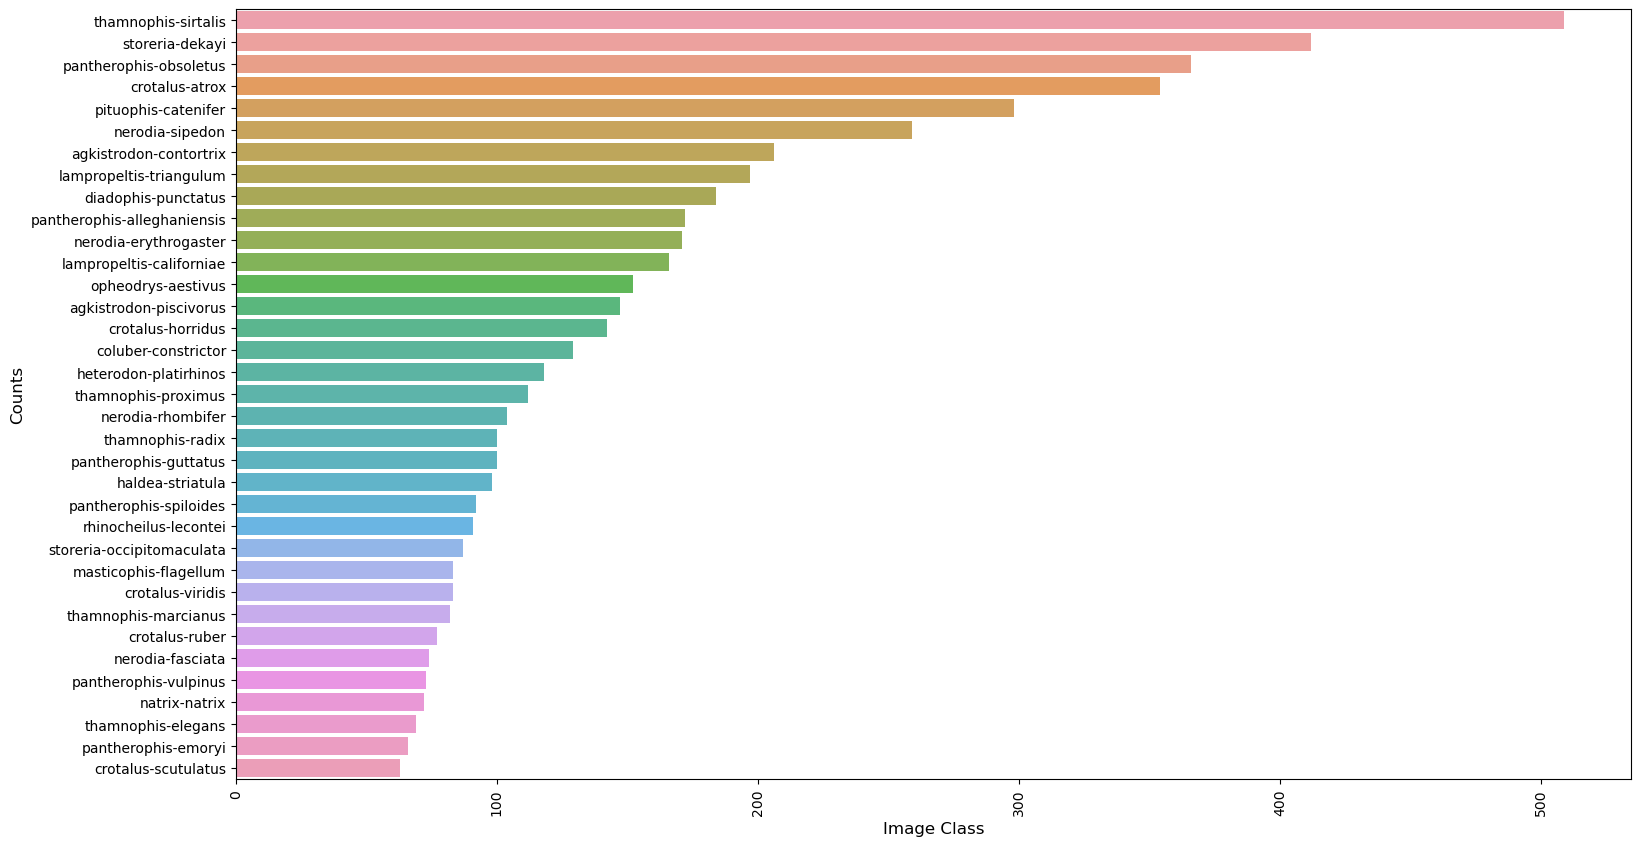

In [9]:
label_counts = train['breed'].value_counts()
plt.figure(figsize = (18,10))
sns.barplot(y = label_counts.index, x = label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [10]:
IMG_SIZE = 224

def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [11]:
from tqdm import tqdm

In [12]:
train_img = []
for img_name in tqdm(train['image_id'].values):
    train_img.append(img_name + '.jpg')

100%|██████████| 5508/5508 [00:00<00:00, 4127608.80it/s]


In [13]:
train['image'] = train_img
train.head()

,image_id,breed,image
0,a8b3ad1dde,nerodia-erythrogaster,a8b3ad1dde.jpg
1,8b492b973d,pantherophis-vulpinus,8b492b973d.jpg
2,929b99ea92,thamnophis-sirtalis,929b99ea92.jpg
3,bbac7385e2,pantherophis-obsoletus,bbac7385e2.jpg
4,ef776b1488,agkistrodon-contortrix,ef776b1488.jpg


In [14]:
train_img = []
for img_name in tqdm(train['image'].values):
    train_img.append(read_img(train_dir + img_name ))

100%|██████████| 5508/5508 [00:02<00:00, 2659.96it/s]


In [15]:
x_train = np.array(train_img, np.float32) / 255

In [16]:
print(x_train.shape)

(5508, 224, 224, 3)


In [17]:
label_list = train['breed'].tolist()
label_numeric = {k: v+1 for v, k in enumerate(set(label_list))}
y_train = [label_numeric[k] for k in label_list]
y_train = np.array(y_train)

In [18]:
from keras.utils import to_categorical

In [19]:
y_train = to_categorical(y_train)

In [20]:
print(y_train.shape)

(5508, 36)


In [21]:
base_model =   applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [22]:
add_model = Sequential([
    data_augmentation,
])
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.3))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
batch_size = 32      
epochs = 50                

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

In [25]:
history=model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs)

/tmp/ipykernel_17464/1388610809.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size),
2023-05-20 23:29:41.096384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50


2023-05-20 23:29:47.400638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-20 23:29:48.068375: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-05-20 23:29:48.069173: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-20 23:29:48.069192: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-05-20 23:29:48.069225: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-20 

  2/172 [..............................] - ETA: 26s - loss: 7.2209 - accuracy: 0.0156  

2023-05-20 23:29:56.960774: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



172/172 [==============================] - 48s 185ms/step - loss: 3.9437 - accuracy: 0.0827
Epoch 2/50
172/172 [==============================] - 30s 172ms/step - loss: 3.4146 - accuracy: 0.0906
Epoch 3/50
172/172 [==============================] - 30s 174ms/step - loss: 3.3941 - accuracy: 0.0919
Epoch 4/50
172/172 [==============================] - 31s 178ms/step - loss: 3.3780 - accuracy: 0.0922
Epoch 5/50
172/172 [==============================] - 31s 177ms/step - loss: 3.3744 - accuracy: 0.0933
Epoch 6/50
172/172 [==============================] - 31s 178ms/step - loss: 3.3679 - accuracy: 0.0966
Epoch 7/50
172/172 [==============================] - 31s 179ms/step - loss: 3.3701 - accuracy: 0.0957
Epoch 8/50
172/172 [==============================] - 31s 182ms/step - loss: 3.3663 - accuracy: 0.0931
Epoch 9/50
172/172 [==============================] - 31s 181ms/step - loss: 3.3624 - accuracy: 0.0977
Epoch 10/50
172/172 [==============================] - 31s 181ms/step - loss: 3.3621

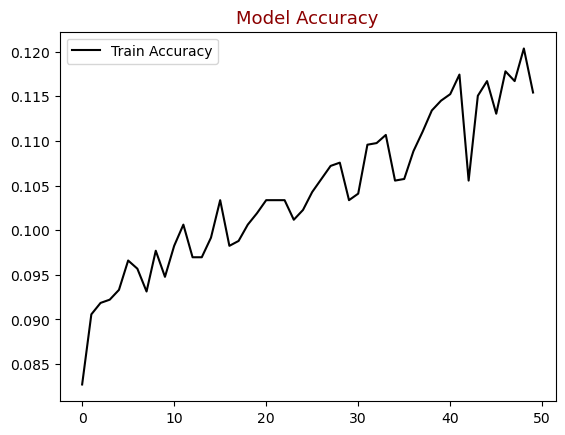

In [26]:
plt.figure()
plt.plot(history.history["accuracy"],label="Train Accuracy",color="black")
# plt.plot(history.history["val_accuracy"],label="Validation Accuracy",color="mediumvioletred",linestyle="dashed",markeredgecolor="purple",markeredgewidth=2)
plt.title("Model Accuracy",color="darkred",size=13)
plt.legend()
plt.show()

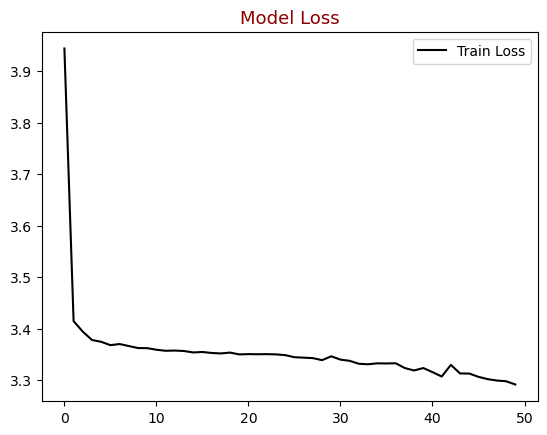

In [27]:
plt.figure()
plt.plot(history.history["loss"],label="Train Loss",color="black")
plt.title("Model Loss",color="darkred",size=13)
plt.legend()
plt.show()

In [28]:
test_img = []
for img_name in tqdm(test['image_id'].values):
    test_img.append(img_name + '.jpg')

100%|██████████| 2361/2361 [00:00<00:00, 2777770.48it/s]


In [29]:
test['image'] = test_img

test_img = []
for img_name in tqdm(test['image'].values): 
    test_img.append(read_img(test_dir + img_name))

100%|██████████| 2361/2361 [00:01<00:00, 1715.24it/s]


In [30]:
x_test = np.array(test_img, np.float32) / 255

In [31]:
predictions = model.predict(x_test)

2023-05-20 23:56:07.001757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1421586432 exceeds 10% of free system memory.
2023-05-20 23:56:07.638103: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1421586432 exceeds 10% of free system memory.


74/74 [==============================] - 6s 54ms/step


In [32]:
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [33]:
output = pd.DataFrame({'image_id': test.image_id, 'pred-breed': pred_labels})
filename = 'solution.csv'
output.to_csv(filename, index=False) 
output.head()

,image_id,pred-breed
0,7ede553357,thamnophis-sirtalis
1,3500b219e4,thamnophis-sirtalis
2,d43a78d6d9,thamnophis-sirtalis
3,1f36f26994,thamnophis-sirtalis
4,8cb85fc58e,thamnophis-sirtalis


In [35]:
output['pred-breed'].unique()

array(['thamnophis-sirtalis', 'pituophis-catenifer', 'crotalus-atrox',
       'pantherophis-obsoletus', 'storeria-dekayi'], dtype=object)

AttributeError: 'DataFrame' object has no attribute 'breed'

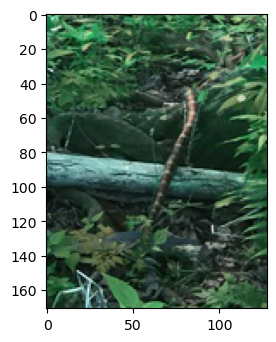

In [36]:
# comparsion of predicted labels with actual labels
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(test_dir + test.image_id[i] + '.jpg')
    plt.imshow(img)
    plt.title("Prediction : " + output.breed[i])
    plt.axis("off")
plt.show()
